# Introduction

### Problem Description

Data-driven approaches are now used in many fields from business to science. Since data storage and computational power has become cheap, machine learning has gained popularity. However, the majority of tools that can extract dependencies from data, are designed for prediction problem. In this notebook a problem of decision support simulation is considered and it is shown that even good predictive models can lead to wrong conclusions. This occurs under some conditions summarized by an umbrella term called endogeneity. In particular, accuracy of predictions does not guarantee causal relationships detection.

Suppose that situation is as follows. There is a freshly-hired manager that can assign treatment to items in order to increase target metric. Treatment is binary, i.e. for each item it is assigned or it is absent. Because treatment costs something, its assignment should be optimized - only some items should be treated. A historical dataset of items performance is given, but the manager does not know that previously treatment was assigned predominantely based on values of just one parameter. Moreover, this parameter is not included in the dataset. By the way, the manager wants to create a system that predicts an item's target metric in case of treatment and in case of absence of treatment. If this system is deployed, the manager can compare these two cases and decide whether effect of treatment worths its costs.

If machine learning approach results in good prediction scores, chances are that the manager does not suspect that important variable is omitted (at least until some expenses are generated by wrong decisions). Hence, domain knowledge and data understanding are still required for modelling based on data. This is of particular importance when datasets contain values that are produced by someone's decisions, because there is no guarantee that future decisions will not change dramatically. On the flip side, if all factors that affect decisions are included into a dataset, i.e. there is selection on observables for treatment assignment, a powerful enough model is able to estimate treatment effect correctly.

### References

To read more about causality in data analysis, it is possible to look at these papers:

1. *Angrist J, Pischke J-S. Mostly Harmless Econometrics. Princeton University Press, 2009.*

2. *Varian H. Big Data: New Tricks for Econometrics. Journal of Economic Perspectives, 28(2): 3–28, 2013*

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use `conda` or `pip` to install any of them.

# Preparations

### General

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Startup settings can not suppress a warning from XGBRegressor and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from xgboost import XGBRegressor

In [2]:
np.random.seed(seed=361)

### Synthetic Dataset Generation

Let us generate an unobservable parameter and an indicator of treatment such that they are highly correlated.

In [3]:
unobservable = np.hstack((np.ones(10000), np.zeros(10000)))
treatment = np.hstack((np.ones(9000), np.zeros(10000), np.ones(1000)))

In [4]:
np.corrcoef(unobservable, treatment)

array([[ 1. ,  0.8],
       [ 0.8,  1. ]])

Now create historical dataset that is used for learning predictive model.

In [5]:
def synthesize_dataset(unobservable, treatment,
                       given_exogenous=None, n_exogenous_to_draw=2,
                       weights_matrix=np.array([[5, 0, 0, 0],
                                                [0, 1, 1, 0],
                                                [0, 1, 2, 1],
                                                [0, 0, 1, 3]]).T):
    """
    A helper function for repetitive
    pieces of code.
    
    Creates a dataset, where target depends on
    `unobservable`, but `unobservable` is not
    included as a feature. Independent features
    can be passed as `given_exogenous` as well as
    drawn from Gaussian distribution.
    
    Target is generated as linear combination of
    features and their interactions in the
    following manner. Order features as below:
    unobservable variable, treatment indicator,
    given exogenous features, drawn exogenous
    features. Then the (i, i)th element of
    `weights_matrix` defines coefficient of
    the i-th feature and the (i, j)th element
    of `weights_matrix` (where i != j) defines
    coefficient of interaction between the i-th
    and j-th features.

    @type unobservable: numpy.ndarray
    @type treatment: numpy.ndarray
    @type given_exogenous: numpy.ndarray
    @type n_exogenous_to_draw: numpy.ndarray
    @type weights_matrix: numpy.ndarray
    @return: numpy.ndarray, numpy.ndarray
    """

    try:
        assert unobservable.shape == treatment.shape
    except AssertionError:
        raise ValueError("`unobservable` and `treatment` are not aligned.")
    try:
        if given_exogenous is not None:
            assert unobservable.shape[0] == given_exogenous.shape[0]
    except AssertionError:
        raise ValueError("`unobservable` and `given_exogenous` are not " +
                         "aligned. Try to transpose `given_exogenous`.")
    try:
        assert weights_matrix.shape[0] == weights_matrix.shape[1]
    except AssertionError:
        raise ValueError("Matrix of weights is not square.")
    try:
        indices = list(range(weights_matrix.shape[0]))
        for i, j in combinations(indices, 2):
            assert weights_matrix[i, j] == weights_matrix[j, i]
    except AssertionError:
        raise ValueError("Matrix of weigths is not symmetric.")
    try:
        len_of_given = given_exogenous.shape[1] \
                       if given_exogenous is not None \
                       else 0
        assert 2 + len_of_given + n_exogenous_to_draw == weights_matrix.shape[0]
    except AssertionError:
        raise ValueError("Number of weights is not equal to that of features.")

    drawn_features = []
    for i in range(n_exogenous_to_draw):
        current_feature = np.random.normal(size=unobservable.shape[0])
        drawn_features.append(current_feature)
    if given_exogenous is None:
        features = np.vstack([unobservable, treatment] + drawn_features).T
    else:
        features = np.vstack([unobservable, treatment, given_exogenous.T] +
                             drawn_features).T
    target = np.dot(features, weights_matrix.diagonal())
    interactions = [weights_matrix[i, j] * features[:, i] * features[:, j]
                    for i, j in combinations(indices, 2)]
    target = np.sum(np.vstack([target] + interactions), axis=0)
    return features[:, 1:], target

In [6]:
learning_X, learning_y = synthesize_dataset(unobservable, treatment)

Now create two datasets for simulation where the only difference between them is that in the first one treatment is absent and in the second one treatment is assigned to all items.

In [7]:
unobservable = np.hstack((np.ones(2500), np.zeros(2500)))

In [8]:
no_treatment = np.zeros(5000)
full_treatment = np.ones(5000)

In [9]:
no_treatment_X, no_treatment_y = synthesize_dataset(unobservable, no_treatment)
full_treatment_X, full_treatment_y = synthesize_dataset(unobservable, full_treatment,
                                                        no_treatment_X[:, 1:], 0)

Look at the data that are used for simulation.

In [10]:
no_treatment_X[:5, :]

array([[ 0.        ,  1.58191727, -1.17154285],
       [ 0.        , -0.56614096, -0.24566541],
       [ 0.        , -0.3521775 ,  2.37789361],
       [ 0.        , -1.19089718, -0.54156554],
       [ 0.        ,  1.41070964, -0.14438024]])

In [11]:
full_treatment_X[:5, :]

array([[ 1.        ,  1.58191727, -1.17154285],
       [ 1.        , -0.56614096, -0.24566541],
       [ 1.        , -0.3521775 ,  2.37789361],
       [ 1.        , -1.19089718, -0.54156554],
       [ 1.        ,  1.41070964, -0.14438024]])

In [12]:
no_treatment_y[:5]

array([  2.79592213,   3.2698031 ,  10.59188519,   1.63845791,   7.18459995])

In [13]:
full_treatment_y[:5]

array([  5.3778394 ,   3.70366215,  11.23970769,   1.44756073,   9.59530959])

# Good Model...

In [14]:
X_train, X_test, y_train, y_test = train_test_split(learning_X, learning_y,
                                                    random_state=361)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15000, 3), (5000, 3), (15000,), (5000,))

In [15]:
def tune_inform(X_train, y_train, rgr, grid_params, kf, scoring):
    """
    Another helper function.
    
    @type X_train: numpy.ndarray
    @type y_train: numpy.ndarray
    @type rgr: any sklearn regressor
    @type grid_params: dict
    @type kf: any sklearn folds
    @type scoring: string
    @return: sklearn regressor
    """
    grid_search_cv = GridSearchCV(rgr, grid_params, cv=kf,
                                  scoring=scoring)
    grid_search_cv.fit(X_train, y_train)
    print("Best CV mean score: {}".format(grid_search_cv.best_score_))
    means = grid_search_cv.cv_results_['mean_test_score']
    stds = grid_search_cv.cv_results_['std_test_score']
    print("Detailed results:")
    for mean, std, params in zip(means, stds,
                                 grid_search_cv.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, 2 * std, params))
    return grid_search_cv.best_estimator_

In [16]:
rgr = LinearRegression()
grid_params = {'fit_intercept': [True, False]}
kf = KFold(n_splits=5, shuffle=True, random_state=361)

Let us use coefficient of determination as a scorer rather than MSE. Actually, they are linearly dependent: $R^2 = 1 - \frac{MSE}{\mathrm{Var}(y)}$, but coefficient of determination is easier to interpret.

In [17]:
rgr = tune_inform(X_train, y_train, rgr, grid_params, kf, 'r2')

Best CV mean score: 0.8597040594785548
Detailed results:
0.860 (+/-0.007) for {'fit_intercept': True}
0.854 (+/-0.008) for {'fit_intercept': False}


In [18]:
y_hat = rgr.predict(X_test)
r2_score(y_test, y_hat)

0.86724859617745653

Although true relationship is non-linear, predictive power of linear regression is good. Coefficient of determination is close to 1 and it means that the model expalins almost all variance of the target around its mean.

In [19]:
rgr = XGBRegressor()
grid_params = {'n_estimators': [50, 100, 200, 300],
               'max_depth': [3, 5],
               'subsample': [0.8, 1]}
kf = KFold(n_splits=5, shuffle=True, random_state=361)

In [20]:
rgr = tune_inform(X_train, y_train, rgr, grid_params, kf, 'r2')

Best CV mean score: 0.9052404587389057
Detailed results:
0.900 (+/-0.008) for {'n_estimators': 50, 'subsample': 0.8, 'max_depth': 3}
0.900 (+/-0.008) for {'n_estimators': 50, 'subsample': 1, 'max_depth': 3}
0.905 (+/-0.010) for {'n_estimators': 100, 'subsample': 0.8, 'max_depth': 3}
0.905 (+/-0.010) for {'n_estimators': 100, 'subsample': 1, 'max_depth': 3}
0.905 (+/-0.011) for {'n_estimators': 200, 'subsample': 0.8, 'max_depth': 3}
0.905 (+/-0.011) for {'n_estimators': 200, 'subsample': 1, 'max_depth': 3}
0.905 (+/-0.011) for {'n_estimators': 300, 'subsample': 0.8, 'max_depth': 3}
0.905 (+/-0.011) for {'n_estimators': 300, 'subsample': 1, 'max_depth': 3}
0.905 (+/-0.009) for {'n_estimators': 50, 'subsample': 0.8, 'max_depth': 5}
0.904 (+/-0.010) for {'n_estimators': 50, 'subsample': 1, 'max_depth': 5}
0.905 (+/-0.010) for {'n_estimators': 100, 'subsample': 0.8, 'max_depth': 5}
0.904 (+/-0.010) for {'n_estimators': 100, 'subsample': 1, 'max_depth': 5}
0.904 (+/-0.010) for {'n_estimators

It looks like almost all combinations of hyperparameters result in error that is close to irreducible error caused by mismatches between the indicator of treatment and the unobservable variable.

In [21]:
y_hat = rgr.predict(X_test)
r2_score(y_test, y_hat)

0.91312756427013864

The score is close to 1 and it deceptively motivates to think that all important variables are included into the model.

# ...and Poor Simulation

In [22]:
no_treatment_y_hat = rgr.predict(no_treatment_X)
r2_score(no_treatment_y, no_treatment_y_hat)

0.47046791439228886

In [23]:
full_treatment_y_hat = rgr.predict(full_treatment_X)
r2_score(full_treatment_y, full_treatment_y_hat)

0.5711456056709403

And now scores are not perfect, are they?

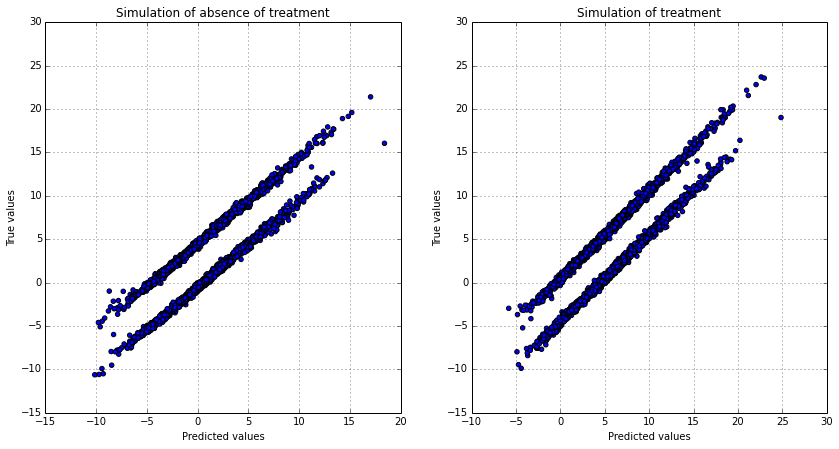

In [24]:
fig = plt.figure(figsize=(14, 7))

ax_one = fig.add_subplot(121)
ax_one.scatter(no_treatment_y_hat, no_treatment_y)
ax_one.set_title("Simulation of absence of treatment")
ax_one.set_xlabel("Predicted values")
ax_one.set_ylabel("True values")
ax_one.grid()

ax_two = fig.add_subplot(122, sharey=ax_one)
ax_two.scatter(full_treatment_y_hat, full_treatment_y)
ax_two.set_title("Simulation of treatment")
ax_two.set_xlabel("Predicted values")
ax_two.set_ylabel("True values")
_ = ax_two.grid()

It can be seen that effect of treatment is overestimated. In case of absence of treatment, for items with unobservable feature equal to 1, predictions are significantly less than true values. To be more precise, the differences are close to coefficient near unobservable feature in `weights_matrix` passed to the dataset creation. Similarly, in case of full treatment, for items with unobservable feature equal to 0, predictions are higher than true values and the differences are close to the abovementioned coefficient too.

Fianlly, let us emulate a wrong decision that the manager can make. Suppose that treatment costs $1 per item and the modelled target variable is revenue in dollars.

In [25]:
estimated_effects = full_treatment_y_hat - no_treatment_y_hat
true_effects = full_treatment_y - no_treatment_y

In [26]:
np.min(estimated_effects)

2.3247685

The model recommends to treat all items. What happens if all of them are treated?

In [27]:
estimated_net_revenue = np.sum(estimated_effects) - estimated_effects.shape[0]
estimated_net_revenue

19665.296875

In [28]:
true_net_revenue = np.sum(true_effects) - true_effects.shape[0]
true_net_revenue

-104.43062664346235

Suddenly, the manager will have small loss instead of solid profit.

# Conclusion

It has been shown that formal metrics used in model evaluation may not reflect all sides of a problem under consideration. Probably, learning sample is biased and is not similar to samples that require predictions. This often occurs when machine learning affects decisions and new decisions differs from those ones that have been made for objects in the learning sample. 

The described case might look too artificial, but below are two real-world examples of similar issues:

* The goal is to train neural network to detect certain phrase in recorded speech. Assume that, unfortunately, all occurrences of the phrase in the learning sample are recorded by the same microphone in the same room and this flaw is not known. As a result, variable that indicates occurrence of the phrase and unobservable variable that indicates used microphone, are confound. Network does not understand which target to learn and so produces good results during cross-validation and on hold-out test set, but poor results in a production environment.

* In labour econometrics, a problem of estimation higher education effect on wages is well-studied. A subtle issue here is that people with higher abilities have more willingness to earn degrees and also they have more chances to have bigger salaries. Abilities are unobservable variable and their effect is attributed mainly to higher education, because there is strong correlation between these variables. Hence, naive modelling leads to overestimation of higher education effect. 

Probably, sections of the notebook that illustrate ways to overcome lack of important unobservable variables, will be released after some time.